Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import itertools 
import re
import csv
from nltk import word_tokenize,pos_tag
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import joblib
import os
import string
import matplotlib as mpl
import itertools    
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk import word_tokenize
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from spellchecker import SpellChecker 
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from sklearn.utils import safe_indexing
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import string
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
import json
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('movie_info.csv')
df.head()

,locale_id,title,id_imdb,genre_imdb
0,1,Toy Story (1995),tt0114709,Animation|Adventure|Comedy|Family|Fantasy
1,2,GoldenEye (1995),tt0113189,Action|Adventure|Thriller
2,3,Four Rooms (1995),tt0113101,Comedy
3,4,Get Shorty (1995),tt0113161,Comedy|Crime|Thriller
4,5,Copycat (1995),tt0112722,Drama|Mystery|Thriller


Removing Null Values of df

In [3]:
df = df.dropna(how = 'any')

In [4]:
df =df.rename(columns = {'locale_id' :'local_id'})

Reading json file... 

In [5]:
data = pd.read_json('movie_synopsis.json')
data=data.transpose()

Removing Null Values of data

In [6]:
data = data.dropna(how = 'any')
data.head()

,imdbID,plot_synopsis,local_id,plot_source
1,tt0114709,A boy called Andy Davis (voice: John Morris) u...,1,imdb
2,tt0113189,"The story opens in 1986, in the Cold War Sovie...",2,imdb
3,tt0113101,The film begins with Ted the Bellhop (Tim Roth...,3,imdb
4,tt0113161,Chilli Palmer (John Travolta) is a loan shark ...,4,imdb
5,tt0112722,After giving a guest lecture on criminal psych...,5,imdb


 change datatype of 'movie_id' 

In [7]:
df['local_id'] = df['local_id'].astype(str)
data['local_id'] = data['local_id'].astype(str)

merge df with data on local id

In [8]:
movies = pd.merge(data, df, on = 'local_id')

In [9]:
movies.head(10)

,imdbID,plot_synopsis,local_id,plot_source,title,id_imdb,genre_imdb
0,tt0114709,A boy called Andy Davis (voice: John Morris) u...,1,imdb,Toy Story (1995),tt0114709,Animation|Adventure|Comedy|Family|Fantasy
1,tt0113189,"The story opens in 1986, in the Cold War Sovie...",2,imdb,GoldenEye (1995),tt0113189,Action|Adventure|Thriller
2,tt0113101,The film begins with Ted the Bellhop (Tim Roth...,3,imdb,Four Rooms (1995),tt0113101,Comedy
3,tt0113161,Chilli Palmer (John Travolta) is a loan shark ...,4,imdb,Get Shorty (1995),tt0113161,Comedy|Crime|Thriller
4,tt0112722,After giving a guest lecture on criminal psych...,5,imdb,Copycat (1995),tt0112722,Drama|Mystery|Thriller
5,tt0115012,Tang Shuisheng (Wang Xiaoxiao) has arrived in ...,6,imdb,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,tt0115012,Crime|Drama|History|Romance|Thriller
6,tt0114746,The story is set in the indeterminate future. ...,7,imdb,Twelve Monkeys (1995),tt0114746,Mystery|Sci-Fi|Thriller
7,tt0112431,"Babe, an orphaned piglet, is chosen for a ""gue...",8,imdb,Babe (1995),tt0112431,Comedy|Drama|Family
8,tt0112818,"A public housing project in New Orleans, LA. K...",9,imdb,Dead Man Walking (1995),tt0112818,Crime|Drama
9,tt0114279,In a fictitious alternate timeline of England ...,10,imdb,Richard III (1995),tt0114279,Drama|Sci-Fi|War


Removing unused columns...

In [10]:
movies.drop(['imdbID' , 'local_id' , 'id_imdb' , 'plot_source'] ,axis=1, inplace=True)

Removing NAN values...

In [11]:
movies.replace('', float("NaN"), inplace=True)
movies.dropna(inplace=True)

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 0 to 1593
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   plot_synopsis  1409 non-null   object
 1   title          1409 non-null   object
 2   genre_imdb     1409 non-null   object
dtypes: object(3)
memory usage: 44.0+ KB


Removing | and make a list out of genre_imdb

In [13]:
genres = []
for i in movies['genre_imdb']:
    genres.append(i.split('|')) 

 We make a copy of synopsis column in order to have preprocessing on the new column

In [14]:
movies['clean_plot'] = movies['plot_synopsis']
movies.head()

,plot_synopsis,title,genre_imdb,clean_plot
0,A boy called Andy Davis (voice: John Morris) u...,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,A boy called Andy Davis (voice: John Morris) u...
1,"The story opens in 1986, in the Cold War Sovie...",GoldenEye (1995),Action|Adventure|Thriller,"The story opens in 1986, in the Cold War Sovie..."
2,The film begins with Ted the Bellhop (Tim Roth...,Four Rooms (1995),Comedy,The film begins with Ted the Bellhop (Tim Roth...
3,Chilli Palmer (John Travolta) is a loan shark ...,Get Shorty (1995),Comedy|Crime|Thriller,Chilli Palmer (John Travolta) is a loan shark ...
4,After giving a guest lecture on criminal psych...,Copycat (1995),Drama|Mystery|Thriller,After giving a guest lecture on criminal psych...


# Preprocessing :

Text preprocessing is an important and one the most essential step before building any model in Natural Language Processing. A raw text corpus, collected from one or many sources, may be full of inconsistencies and ambiguity that requires preprocessing for cleaning it up.

Removing names from synopsis...

In [15]:
# remove name
movies["clean_plot"] = movies["clean_plot"].astype(str)
def remove_name(text):
    with open('names.txt') as f:
        NAMES = set(f.read().splitlines())

    # find all the words that look like names
    pattern = r"(\b[A-Z][a-z]+('s)?\b)"
    found_names = re.findall(pattern, text)

    # get singular forms, and remove doubles
    found_names = set([name[0].replace("'s","") for name in found_names])

    # remove all the words that look like names but are not included in the NAMES
    found_names = [name for name in found_names if name in NAMES]

    # loop trough the found names and remove every name from the text
    for name in found_names:
        text = re.sub(name + "('s)?", "", text) # include plural forms

    return text
movies['clean_plot'] = movies['clean_plot'].apply(lambda x:remove_name(x))
movies.head()

,plot_synopsis,title,genre_imdb,clean_plot
0,A boy called Andy Davis (voice: John Morris) u...,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,A boy called (voice: ) uses his toys to act...
1,"The story opens in 1986, in the Cold War Sovie...",GoldenEye (1995),Action|Adventure|Thriller,"The story opens in 1986, in the Cold War Sovie..."
2,The film begins with Ted the Bellhop (Tim Roth...,Four Rooms (1995),Comedy,The film begins with the Bellhop ( ) in a roo...
3,Chilli Palmer (John Travolta) is a loan shark ...,Get Shorty (1995),Comedy|Crime|Thriller,Chilli ( Travolta) is a loan shark living in ...
4,After giving a guest lecture on criminal psych...,Copycat (1995),Drama|Mystery|Thriller,After giving a guest lecture on criminal psych...


Lowercasing...

The lowercasing is an important text preprocessing step in which we convert the text into the same casing, preferably all in lowercase so that the words America, America, and AMERICA can be treated in the same way as “america”.

It is helpful in text featurization techniques like term frequency, TFIDF since it prevents duplication of same words having different casing.

In our example, we have used the lower() function of python to convert all the text in the dataframe to the lower case.

In [16]:
# Lowercasing
movies['clean_plot']=movies['clean_plot'].str.lower()

Removing whitespaces...

A text may contain extra whitespace which is not desired as they increase the text size and not add any value to the data. Hence removing extra whitespace is a trivial but important text preprocessing step.

In Python, we can do this by splitting the text and joining it back on the basis of single whitespace. In our example, we have created a function remove_whitespace() and apply it to the dataframe.

In [17]:
def remove_whitespace(text):
    return  " ".join(text.split())

movies['clean_plot']=movies['clean_plot'].apply(remove_whitespace)

Removing punctuations...

Removing punctuation is an important text preprocessing step as it also does not add any value to the information. This is a text standardization process that will help to treat words like ‘some.’, ‘some,’, and ‘some’ in the same way.

In Python NLTK, we can make use RegexpTokenizer module for removing punctuations from the text.

In our example, we have created a custom function remove_punctuation() that removes punctuations from the text passed to it as a parameter, and then it is applied to Twitter dataframes.

In [18]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the punctuation free text
movies['clean_plot']= movies['clean_plot'].apply(lambda x:remove_punctuation(x))

movies.head()

,plot_synopsis,title,genre_imdb,clean_plot
0,A boy called Andy Davis (voice: John Morris) u...,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,a boy called voice uses his toys to act out a...
1,"The story opens in 1986, in the Cold War Sovie...",GoldenEye (1995),Action|Adventure|Thriller,the story opens in 1986 in the cold war soviet...
2,The film begins with Ted the Bellhop (Tim Roth...,Four Rooms (1995),Comedy,the film begins with the bellhop in a room f...
3,Chilli Palmer (John Travolta) is a loan shark ...,Get Shorty (1995),Comedy|Crime|Thriller,chilli travolta is a loan shark living in mia...
4,After giving a guest lecture on criminal psych...,Copycat (1995),Drama|Mystery|Thriller,after giving a guest lecture on criminal psych...


Removing stopwords...

Stopwords are trivial words like “I”, “the”, “you”, etc. that appear so frequently in the text that they may distort many NLP operations without adding much valuable information. So almost always you will have to remove stopwords from the corpus as part of your preprocessing.

NLTK library maintains a list of around 179 stopwords (shown below) that can be used to filtering stopwords from the text. You may also add or remove stopwords from the default list.

In [19]:
# remove stopwords function
movies["clean_plot"] = movies["clean_plot"].astype(str)
def remove_stopwords(text):
    pronouns = ['i', 'he', 'she', 'it', 'him', 'they', 'we', 'us', 'them' , 'tell']
    others = ['tell', 'go', 'take', 'man', 'one', 'back', 'try', 'two','s','also', 'become', 'away', 'next', 'barnes',
              'name','first', 'however','still','would', 'get', 'see', 'make', 'ask', 'come', 'sar', 'tell', 'sid',
              'new', 'know', 'later', 'want', 'look','another','well', 'wed' , 'pinocchio', 'ugolin','say', 'torino',
              'find', 'leave', 'ed', 'le', 'give', 'mr', 'did','turn', 'end','film', 'go', 'take', 'find', 'nomi', 'herod',
              'set', 'three', 'even', 'several', 'place', 'meanwhile', 'finally', 'soon','talk', 'use', 'leave', 'genevi',
              'continue', 'last', 'together', 'never', 'dr', 'able', 'agree', 'allow', 'begin', 'believe', 'bring', 'od',
              'change', 'belasco', 'muffy', 'leeloo', 'mccabe', 'sub', 'kinjanja', 'hyp', 'chizhov', 'ande', 'littlefoot',
              'simba', 'boffano', 'helsing', 'renfield', 'nosferatu', 'lestat', 'hutter', 'voysey', 'kotov', 'pittsburgh',
              'arizona', 'winger', 'bilko', 'robbin', 'hatchett', 'mowgli', 'ripley', 'spock', 'mccoy', 'picard', 'mcclane',
              'kelso', 'leary', 'dc', 'chekhovs', 'miss', 'jos', 'desdemona', 'brighton', 'crockett', 'simms', 'get', 'make',
              'deckard', 'minton', 'las', 'vegas', 'dumbo', 'norbu', 'albrecht', 'roseman', 'orlok', 'katherine', 'indy', 'call',
              'mrs', 'gotham', 'barne' , 'ny' , 'tell', 'michael' , 'siku','alvarez', 'nagiko', 'moore', 'milner' , 'robert']
    
    stop_words = set(stopwords.words("english") + pronouns + others)
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text


movies['clean_plot'] = movies['clean_plot'].apply(remove_stopwords)
movies.head()


,plot_synopsis,title,genre_imdb,clean_plot
0,A boy called Andy Davis (voice: John Morris) u...,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,"[boy, called, voice, uses, toys, act, bank, ro..."
1,"The story opens in 1986, in the Cold War Sovie...",GoldenEye (1995),Action|Adventure|Thriller,"[story, opens, 1986, cold, war, soviet, union,..."
2,The film begins with Ted the Bellhop (Tim Roth...,Four Rooms (1995),Comedy,"[begins, bellhop, room, filled, hotel, memorab..."
3,Chilli Palmer (John Travolta) is a loan shark ...,Get Shorty (1995),Comedy|Crime|Thriller,"[chilli, travolta, loan, shark, living, miami,..."
4,After giving a guest lecture on criminal psych...,Copycat (1995),Drama|Mystery|Thriller,"[giving, guest, lecture, criminal, psychology,..."


Lemmatization...

Lemmatization is converting the word to its base form or lemma by removing affixes from the inflected words. It helps to create better features for machine learning and NLP models hence it is an important preprocessing step.
There are many Lematizers available in NLTK that employ different algorithms. In our example, we have used WordNetLemmatizer module of NLTK for lemmatization.

In [20]:
def lemmatization(text):
    
    result=[]
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))
    
    return result

movies['clean_plot']=movies['clean_plot'].apply(lemmatization)

Stemming also reduces the words to their root forms but unlike lemmatization, the stem itself may not a valid word in the Language.

# Stemming v/s Lemmatization

Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
For instance, stemming the word ‘Caring‘ would return ‘Car‘.Stemming is used in case of large dataset where performance is an issue.

Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.For instance, lemmatizing the word ‘Caring‘ would return ‘Care‘.Lemmatization is computationally expensive since it involves look-up tables and what not.

Lemmatization and Stemming are the foundation of derived (inflected) words and hence the only difference between lemma and stem is that lemma is an actual word whereas, the stem may not be an actual language word.
Lemmatization uses a corpus to attain a lemma, making it slower than stemming. Further, to get the proper lemma, you might have to define a parts-of-speech. Whereas, in stemming a step-wise algorithm is followed making it faster.

The above points show that stemming should be used if speed is important since lemmatizers scan a corpus which is a time-consuming task. Further, the choice between lemmatizers and stemmers also depends on the problem you are working on.

# ----------------------------------------------------------------------------------------------------------

# Finding Frequent Words

We could find frequent words and plot them through the code below:
This function below can visualize the words with their frequencies, in a set of documents

In [21]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

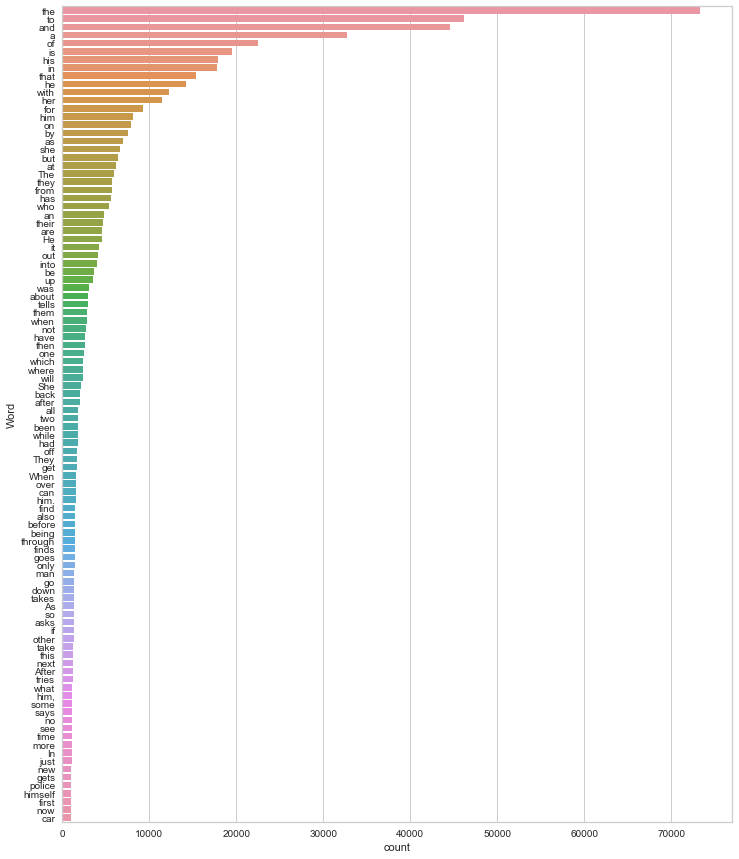

In [22]:
 # print 100 most frequent words before Data cleaning
movies['plot_synopsis'] = movies['plot_synopsis'].astype(str)
freq_words(movies['plot_synopsis'], 100)

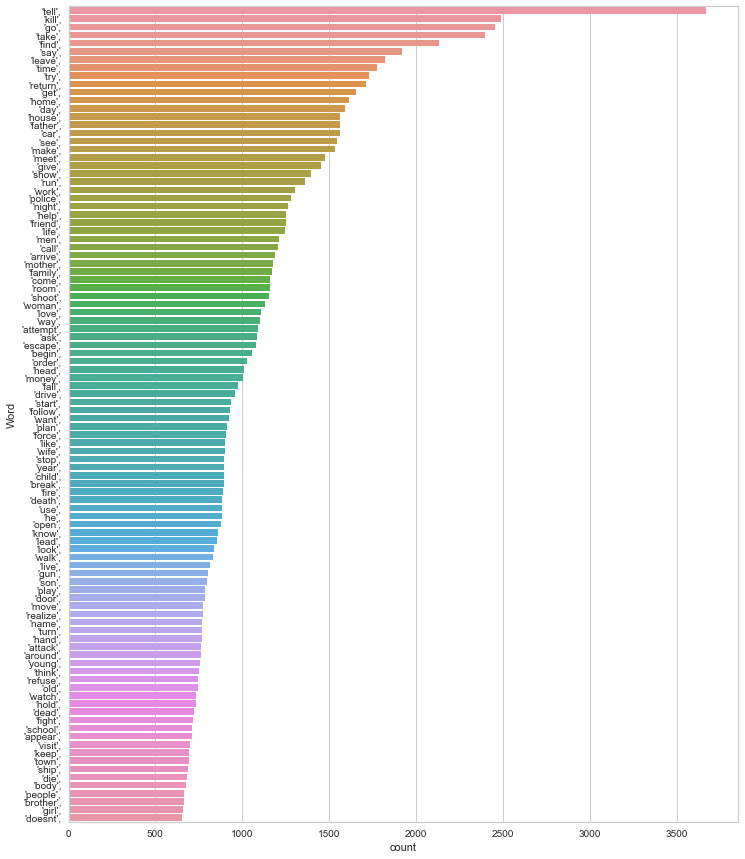

In [23]:
 # print 100 most frequent words
movies['clean_plot'] = movies['clean_plot'].astype(str)
freq_words(movies['clean_plot'], 100)

As you see frequent words are different before and after data cleaning.so we successfully cleaned our stop words.

We can also see how many times each word is repeated:

In [24]:
n_plots = len(movies['clean_plot'])
s_words = 'english' # Stop Word Dictionary
ngram = (1,3) # n-gram POS modeling
plots = movies['clean_plot'].map(str)
tfidf=True
# Word Frequency
cv = CountVectorizer(max_df=0.9, min_df=3, max_features=None, ngram_range=ngram)
tf1 = cv.fit_transform(plots)
terms1 = cv.get_feature_names()
term_sums = tf1.sum(axis=0)
term_counts = []
out1 = []
out2 = []
for i in range(len(terms1)):
    term_counts.append([terms1[i], term_sums[0,i]])
def sortSecond(e):
    return e[1]
term_counts.sort(key=sortSecond, reverse=True)
print("\nTerms with Highest Frequency:")
for i in range(400):
    print('{:<15s}{:>5d}'.format(term_counts[i][0], term_counts[i][1]))
    out1.append([term_counts[i][0], term_counts[i][1]])
np.savetxt("frequency_100.csv", out1, delimiter=",", fmt='%s')
print("")


Terms with Highest Frequency:
tell            3675
kill            2494
go              2455
take            2404
find            2133
say             1923
leave           1825
time            1782
try             1730
return          1717
get             1654
home            1624
day             1596
father          1571
house           1567
car             1565
see             1545
make            1531
meet            1478
give            1457
show            1401
run             1363
work            1314
police          1286
life            1275
night           1265
friend          1260
help            1254
men             1211
call            1204
arrive          1190
mother          1183
family          1179
come            1163
room            1159
shoot           1152
woman           1137
love            1121
way             1107
attempt         1088
begin           1087
ask             1085
escape          1082
order           1028
head            1013
money           1005
fal

We can use this code to extract all the genres from the movies data :

In [25]:
genres = []
for i in movies['genre_imdb']:
    genres.append(i.split('|')) 
genres

[['Animation', 'Adventure', 'Comedy', 'Family', 'Fantasy'],
 ['Action', 'Adventure', 'Thriller'],
 ['Comedy'],
 ['Comedy', 'Crime', 'Thriller'],
 ['Drama', 'Mystery', 'Thriller'],
 ['Crime', 'Drama', 'History', 'Romance', 'Thriller'],
 ['Mystery', 'Sci-Fi', 'Thriller'],
 ['Comedy', 'Drama', 'Family'],
 ['Crime', 'Drama'],
 ['Drama', 'Sci-Fi', 'War'],
 ['Crime', 'Drama', 'Mystery', 'Thriller'],
 ['Crime', 'Drama', 'Mystery', 'Thriller'],
 ['Comedy', 'Drama', 'Fantasy', 'Romance'],
 ['Drama', 'Music'],
 ['Comedy'],
 ['Action', 'Crime', 'Horror'],
 ['Drama', 'Family'],
 ['Comedy', 'Drama'],
 ['Drama', 'Romance'],
 ['Action', 'Adventure', 'Comedy', 'Family', 'Musical', 'Romance'],
 ['Biography', 'Drama', 'History', 'War'],
 ['Crime', 'Drama'],
 ['Action', 'Comedy', 'Crime', 'Thriller'],
 ['Comedy'],
 ['Comedy', 'Drama', 'Romance'],
 ['Action', 'Comedy', 'Crime', 'Thriller'],
 ['Adventure', 'Drama', 'History'],
 ['Action', 'Adventure'],
 ['Action', 'Drama', 'Thriller', 'War'],
 ['Action', '

The genres are now in the list format which is going to be helpful since we will have to access these genre tags later.
If we want to know which all movie genres have been covered in this dataset, then the following code will be useful for us.

In [26]:
all_genres = sum(genres,[])
len(set(all_genres))

24

There are over 24 unique genre tags in our dataset. That is quite a big number. I can hardy recall 5-6 genres. So, let's find out what are these tags. We will use FreqDist( ) of the nltk library to create a dictionary of genres and their occurence count across the dataset.

In [27]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

 Let's plot the distribution of the movie genres.

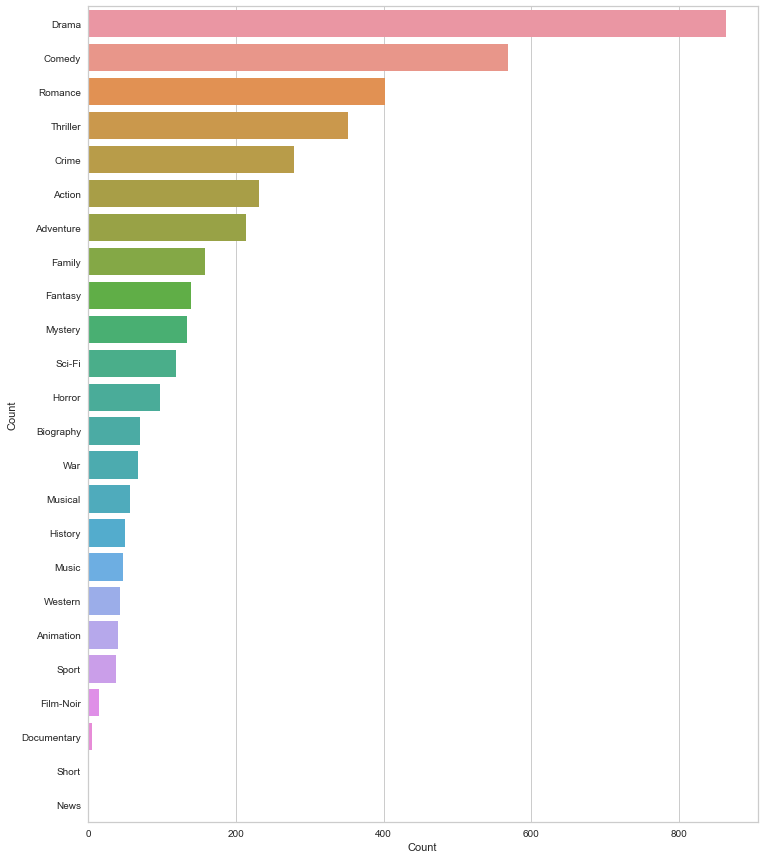

In [28]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

We also can see frequent words for each genre through the code below :

In [29]:
def freq_dist_of_words_for_each_genre(genre):
    plot = movies.loc[movies['genre_imdb'].str.contains(genre), ['clean_plot']]
    plotlist = [x for x in plot['clean_plot'].str.split()]
    plotlist = list(itertools.chain(*plotlist))

    count = CountVectorizer()
    docs     = count.fit_transform(plotlist)
    features = count.get_feature_names()

    fig = plt.figure(figsize=(5, 5) )
    plt.suptitle('%s : Frequency Distribution of Top 10 Words in Plot description' % genre, size = 15)
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 10)
    plt.gcf().subplots_adjust(left=0.15 )
    
    visualizer = FreqDistVisualizer(features = features, n=10, orient='h', color = ['skyblue','pink' ,'purple'])
    visualizer.fit(docs)
    
    
   

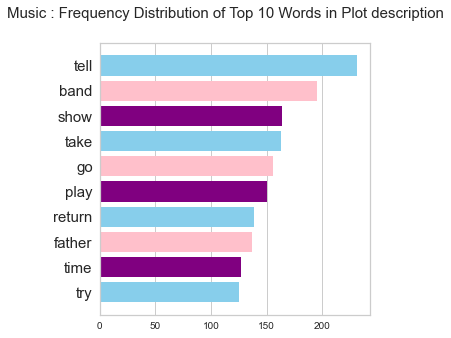

In [30]:
# music
freq_dist_of_words_for_each_genre("Music")

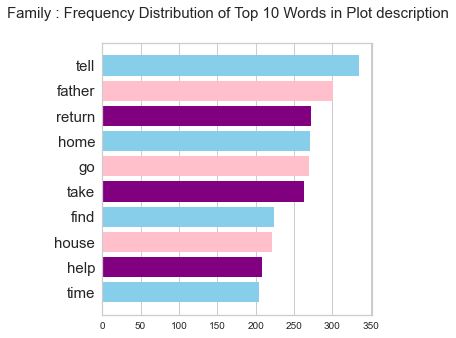

In [31]:
# family
freq_dist_of_words_for_each_genre("Family")

# Feature Extraction

A word embedding is a learned representation for text where words that have the same meaning have a similar representation.
One of the benefits of using dense and low-dimensional vectors is computational: the majority of neural network toolkits do not play well with very high-dimensional, sparse vectors.The main benefit of the dense representations is generalization power: if we believe some features may provide similar clues, it is worthwhile to provide a representation that is able to capture these similarities.Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.Each word is represented by a real-valued vector, often tens or hundreds of dimensions. This is contrasted to the thousands or millions of dimensions required for sparse word representations, such as a one-hot encoding.

There are a lot of algorithms and techniques for word embedding such as : Word2Vec ,GloVe ,  Embedding Layer , bag of word , TFIDF , BERT , one hot encoding ,CBOW , Skip-Gram ,  ...

We will briefly explain TF-IDF method :

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.
The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.
The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.
So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.
Multiplying these two numbers results in the TF-IDF score of a word in a document. The higher the score, the more relevant that word is in that particular document.

# --------------------------------------------------------------------------------------------------------

In addition to calculating word frequency we will now calculate TF-IDF score of every word to see and extract which words have a higher score and can be used as features in clustering.

In [32]:
if tfidf == True:
    # Construct the TF/IDF matrix from the data
    print("Conducting Term/Frequency Matrix using TF-IDF")
    tfidf_vect = TfidfVectorizer(max_df=0.7, min_df=5, max_features=None, ngram_range=ngram)
    tf = tfidf_vect.fit_transform(plots)
    terms = tfidf_vect.get_feature_names()
    term_idf_sums = tf.sum(axis=0)
    term_idf_scores = []
    for i in range(len(terms)):
        term_idf_scores.append([terms[i], term_idf_sums[0,i]])
    print("The Term/Frequency matrix has", tf.shape[0], " rows, and",
        tf.shape[1], " columns.")
    print("The Term list has", len(terms), " terms.")
    
    term_idf_scores.sort(key=sortSecond, reverse=True)
    print("\nTerms with Highest TF-IDF Scores:")
    for i in range(100):
        print('{:<15s}{:>8.2f}'.format(term_idf_scores[i][0], 
        term_idf_scores[i][1]))
        out2.append([term_idf_scores[i][0], term_idf_scores[i][1]])
        np.savetxt("tfidf1_100.csv", out2, delimiter=",", fmt='%s')

Conducting Term/Frequency Matrix using TF-IDF
The Term/Frequency matrix has 1409  rows, and 13740  columns.
The Term list has 13740  terms.

Terms with Highest TF-IDF Scores:
tell              38.86
kill              35.48
father            31.24
go                29.97
take              28.92
find              27.61
house             26.76
home              26.18
family            26.14
mother            25.07
day               24.99
return            24.97
love              24.92
leave             24.32
police            24.20
car               24.14
time              23.78
friend            23.76
get               23.53
life              23.31
try               23.07
meet              22.95
say               22.92
woman             21.67
work              21.37
money             20.87
make              20.87
show              20.53
child             20.41
see               20.36
run               20.12
night             20.11
give              20.09
help              19.79
men      

CountVectorizer is also  a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis).
CountVectorizer creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is nothing but the count of the word in that particular text sample.  This can be visualized as follows:

 Creating a dataframe of all frequent words from count_vectorizer :

In [33]:
k = tf1.todense()
freq = pd.DataFrame(k,columns = terms1)
freq_words = freq.sum(axis = 0)
freq = freq.append(freq_words,ignore_index = True)

# Transposing and rearranging
freq.t = freq.T
freq.t = freq.t.reset_index()
freq.t = freq.t.drop(['index'],axis = 1)
freq.t.index = terms1
freq.t.columns.values[250] = "freq_sum"
freq.t = freq.t.sort_values("freq_sum",ascending = False)

<ipython-input-33-e9ba51dbeeda>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  freq.t = freq.T


In [34]:
freq.t.head()

,0,1,2,3,4,5,6,7,8,9,...,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409
bug,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,104
squad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101
planet,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,181
surface,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,117
kill,1,7,0,4,9,3,3,2,9,1,...,0,1,3,0,0,0,0,0,0,2494


 Taking top words from the entire dataframe based on freq words plot

In [35]:
words_df = freq.t.T
top_words = ['tell', 'go', 'take', 'find', 'get', 'one', 'leave', 'back', 
             'see', 'make']

df = words_df[top_words]
df_encoded = df
df_encoded[df_encoded!=0] = 1

<ipython-input-35-9b33da29ec61>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[df_encoded!=0] = 1
C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\frame.py:3215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [36]:
df_encoded

,tell,go,take,find,get,one,leave,back,see,make
0,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,1,0,0,0
2,1,1,1,1,1,0,1,0,1,1
3,1,1,1,1,1,0,1,0,0,1
4,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1405,0,0,0,0,0,0,0,0,0,0
1406,0,0,1,0,0,0,0,0,0,0
1407,0,1,0,0,0,0,0,0,1,0
1408,1,1,1,1,1,0,1,0,1,1


I decided to use TF-IDF feature extraction method for Clustering ...

# Clustering

There are different type of clustering algorithms such as DBScan , Kmeans , spectral clustering , ... We use kmeans in our approach because of these Advantages:

The K-means clustering algorithm is used to group unlabeled data set instances into clusters based on similar attributes. It has a number of advantages over other types of machine learning models, including the linear models, such as logistic regression and Naive Bayes.

Here are the advantages:

Unlabeled Data Sets
A lot of real-world data comes unlabeled, without any particular class. The benefit of using an algorithm like K-means clustering is that we often do not know how instances in a data set should be grouped. 

For example, consider the problem of trying to group viewers of Netflix into clusters based on similar viewing behavior. We know that there are clusters, but we do not know what those clusters are. Linear models will not help us at all with these sorts of issues.

Nonlinearly Separable Data
Consider the data set below containing a set of three concentric circles. It is nonlinearly separable. In other words, there is no straight line or plane that we could draw on the graph below that can easily discriminate the colored classes red, blue, and green. Using K-means clustering and converting the coordinate system below from Cartesian coordinates to Polar coordinates, we could use the information about the radius to create concentric clusters.

concentric-clusters
Simplicity
The meat of the K-means clustering algorithm is just two steps, the cluster assignment step and the move centroid step. If we’re looking for an unsupervised learning algorithm that is easy to implement and can handle large data sets, K-means clustering is a good starting point. 

Availability
Most of the popular machine learning packages contain an implementation of K-means clustering.

Speed
Based on my experience using K-means clustering, the algorithm does its work quickly, even for really big data sets.


You’ll define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster.Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.
In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids

It halts creating and optimizing clusters when either:

The centroids have stabilized — there is no change in their values because the clustering has been successful.

The defined number of iterations has been achieved.

# --------------------------------------------------------------------------------------------------------

In [37]:
titles = movies['title'].tolist()
synopses = movies['clean_plot'].tolist()
genres = [genres.append(i.split('|')) for i in movies['genre_imdb']]

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)

#fit the vectorizer to synopses
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

(1409, 40943)


#  Using ELBOW method to find the optimal k

The elbow method is used to determine the optimal number of clusters in k-means clustering. The elbow method plots the value of the cost function produced by different values of k. As you know, if k increases, average distortion will decrease, each cluster will have fewer constituent instances, and the instances will be closer to their respective centroids. However, the improvements in average distortion will decline as k increases. The value of k at which improvement in distortion declines the most is called the elbow, at which we should stop dividing the data into further clusters.

We can easily run K-Means for a range of clusters using a for loop and collecting the distortions into a list. but before doing this we should normalize the values through the min-max scaler using the code below: 

In [39]:
mms = MinMaxScaler()
mms.fit(df_encoded)
data_transformed = mms.transform(df_encoded)

Running K-Means with a range of k

In [40]:
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_transformed)
    distortions.append(kmeanModel.inertia_)

 Plotting the distortions of K-Means

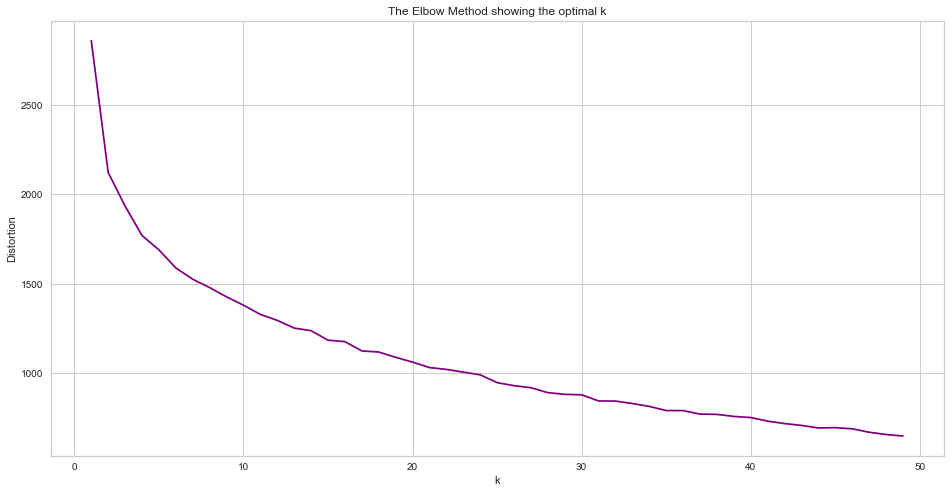

In [41]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-' , color = "purple")
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As can be seen , the elbow is at the index 10, so we can estimate the number of clusters to be 10. 

# KMeans Clustering

In [42]:
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [43]:
joblib.dump(km, 'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
films = { 'title': titles, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts()
frame

,title,cluster
5,Toy Story (1995),5
1,GoldenEye (1995),1
5,Four Rooms (1995),5
3,Get Shorty (1995),3
3,Copycat (1995),3
...,...,...
0,Mirage (1995),0
6,"War at Home, The (1996)",6
6,Sweet Nothing (1995),6
0,B. Monkey (1998),0


this table shows that each movie belongs to which cluster .for example: the movie "Toy Story (1995)" and "Four Rooms (1995)" are in the same cluster .it means these movies are similar to each other.

In [44]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :5]:
        print (' %s' % terms[ind], end=',')
    print()

Top terms per cluster:
Cluster 0:
 love, woman, life, relationship, friend,
Cluster 1:
 ship, crew, kill, alien, captain,
Cluster 2:
 character, story, young, parent, mother,
Cluster 3:
 police, kill, car, murder, killer,
Cluster 4:
 vampire, dracula, blood, coffin, sassy,
Cluster 5:
 tell, say, house, car, room,
Cluster 6:
 family, father, school, mother, home,
Cluster 7:
 president, love, day, time, fashion,
Cluster 8:
 team, game, player, coach, tornado,
Cluster 9:
 oil, water, shark, boat, brother,


The table shows that the movie named " War at home " is in cluster number 4 .in cluster number 4 we have these words: 'mother' , 'father' , 'family' , 'home' .so we can guess that the "War at home" 's genre might be Family genre...

In other example "four rooms" belongs to cluster number 3 and in cluster number 3 there are 'kill' , 'police' , 'car' , ... so it indicate that the genre of this film must be crime , ...